In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from upsetplot import UpSet

In [2]:
def get_new_papers(labelled_data, fetched_pages) : 
    left_join = pd.merge(
        fetched_pages,
        labelled_data,
        on="url",
        how="left",
        suffixes=("", "_labelled"), 
        indicator=True,
    )
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    only_in_fetched = left_join[left_join["_merge"] == "left_only"].drop(columns=["_merge"])
    return(only_in_fetched)

def get_already_labelled_papers(original_dataset, fetched_pages):
    left_join = pd.merge(
        fetched_pages,
        original_dataset,
        on="url",
        how="left",
        suffixes=("", "_labelled"),
        indicator=True,
    )
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    already_labelled = left_join[left_join["_merge"] == "both"].drop(columns=["_merge"])
    already_labelled.drop(columns=["relevance"], inplace=True)
    return already_labelled

def get_topk_threshold(fetched_pages, top_k):
    sorted_pages = fetched_pages.sort_values(by='score', ascending=False)
    if top_k > len(sorted_pages):
        topk_score = sorted_pages.iloc[-1]['score']
    else : 
        topk_score = sorted_pages.iloc[top_k - 1]['score']
    return(topk_score)

def keep_above_threshold(thresholds,fetched_pages):
    kept = fetched_pages[fetched_pages['score'] >= thresholds]
    return(kept)

def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

def sep_by_query(session_infos, fetched_pages):
    papers_by_query = {}
    queries = remove_duplicates(list(session_infos['all_queries'])[0].split(';'))
    
    for query in queries:
        papers = fetched_pages[fetched_pages['get_with_query'] == query]
        papers_by_query[query]=papers
    return(papers_by_query)

def get_cumulative_papers(query_dict):
    cumulative_papers = {}
    seen_papers = pd.DataFrame()  # DataFrame initial pour cumuler les papiers
    for query, papers in query_dict.items():
        # Ajouter les nouveaux papiers
        seen_papers = pd.concat([seen_papers, papers]).drop_duplicates().reset_index(drop=True)
        # Créer un DataFrame pour la query en cours avec les colonnes des DataFrames originaux
        cumulative_papers[query] = seen_papers.copy()
    return cumulative_papers

def keep_topk_by_query(session_infos, fetched_pages, top_k):
    papers_by_query = sep_by_query(session_infos, fetched_pages)
    cumulative_papers_by_query = get_cumulative_papers(papers_by_query)
    kept_papers_by_query = {}
    for query, papers in cumulative_papers_by_query.items() : 
        threshold = get_topk_threshold(papers, top_k)
        kept_papers = keep_above_threshold(threshold, papers)
        # print(f'nb pages found to query:{len(papers)}')
        # print(f'nb papers kept by query : {len(kept_papers)}')
        kept_papers_by_query[query]=kept_papers
    return(kept_papers_by_query)

def recall_precision(fetched_pages, labelled_dataset) : 
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]
    recall = len(relevants) / len(labelled_data_relevants) if len(labelled_data_relevants) > 0 else 0
    precision = len(relevants) / len(merged_data) if len(merged_data) > 0 else 0
    return(recall, precision)

def get_relevants(fetched_pages, labelled_dataset):
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]
    return(relevants)

In [18]:
# initial_query = 'RAG_AND_"code_generation"/'
# initial_query = '"Machine_Learning"_AND_(diffusion_OR_diffusivity)_AND_(MOFs_OR_ZIFs_OR_"metal-organic_frameworks"_OR_COFs_OR_"covalent-organic_frameworks)/'
initial_query = '"metal-organic_frameworks"_AND_"material_design"_AND_"properties"/'

base_path = f'/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/results/{initial_query}'
original_dataset = pd.read_csv(base_path +'original_dataset.csv', sep=';')
labelled_new_papers_path =base_path + "new_papers_to_label.csv"
path_baseline = base_path + 'baseline/'
path_seed_query_expand = base_path + 'SeedQueryBasedTemplate__/'
path_most_relevant_expand = base_path + 'MostRelevantPagesBasedTemplate_MostRelevantPagesPromptBasedTemplate_HydeBasedTemplate/'
path_most_relevant_expand_hyde_prompt = base_path + 'MostRelevantPagesPromptBasedTemplate_HydeSimilarityClassifier_HydePromptBasedTemplate/'
path_seed_query_expand_hyde_prompt = base_path + 'SeedQueryPromptBasedTemplate_HydeSimilarityClassifier_HydePromptBasedTemplate/'
path_classifier_sim_cos = base_path + 'classifiers/sim_cos/'
path_classifier_hyde_sim_cos = base_path + 'classifiers/hyde/'
path_classifier_hyde_sim_cos_description = base_path + 'classifiers/hyde_description/'
crawlers = {'config0_baseline':path_baseline,
            'config1_seed-query_sim_cos':path_seed_query_expand+'sim_cos/',
            'config2_seed-query_hyde-sim-cos':path_seed_query_expand+'hyde_sim_cos/',
            'config3_seed-query_hyde-sim-cos_description':path_seed_query_expand_hyde_prompt,
            'config4_best-paper_hyde-sim-cos':path_most_relevant_expand,
            'config5_best-paper_hyde-sim-cos_description':path_most_relevant_expand_hyde_prompt,
            # 'classifier_sim_cos' : path_classifier_sim_cos,
            # 'classifier_hyde_sim_cos' : path_classifier_hyde_sim_cos,
            # 'classifier_hyde_sim_cos_description' : path_classifier_hyde_sim_cos_description,
}          

top_k = 50

In [38]:
# relevants = original_dataset[original_dataset['relevance']==1]
# for index, row in relevants.iterrows():
#     print(index)

# original_dataset['relevance'] = original_dataset['relevance'].fillna(0)

0
1
13
63
135


In [78]:
# session_infos = pd.read_csv(path_classifier_sim_cos + 'session.csv', sep=';')
# print(session_infos.columns)
# session_infos.to_csv(path_classifier_sim_cos + 'session.csv', index=False)

# fetch = pd.read_csv(path_classifier_hyde_sim_cos_description +'fetched_pages.csv', sep=',')
# # # fetch.drop(columns=['Unnamed: 0'], inplace=True)
# fetch['get_with_query'] ='''"Machine Learning" AND (diffusion OR diffusivity) AND (MOFs OR ZIFs OR "metal-organic frameworks" OR COFs OR "covalent-organic frameworks)'''

# fetch.to_csv(path_classifier_hyde_sim_cos_description +'fetched_pages.csv', index=False)


In [101]:
# df = pd.read_csv(labelled_new_papers_path, sep=',')
# print(len(df))
# df['relevance'] = df['relevance'].fillna(0)
# df.to_csv(labelled_new_papers_path, index=False)
# df.columns


In [49]:
# def reform_sessions_infos(crawler_path):
#     df = pd.read_csv(crawler_path +'session_infos.csv')
#     session_name = str(df['session_name'].iloc[0])
#     searcher = str(df['searcher'].iloc[0])
#     query_expansion = str(df['query_expansion'].iloc[0])
#     classifier = str(df['classifier'].iloc[0])
#     queries = str(df['nb_pages_per_request'].iloc[0])
#     nb_seed_pages = str(df['stop_criteria'].iloc[0])
#     duration = str(df['all_queries'].iloc[0])
#     hyde = str(df['threshold'].iloc[0])
#     nb_fetched_pages = str(df['hyde'].iloc[0])
#     cols = ['session_name', 'searcher', 'query_expansion', 'classifier', 'all_queries', 'nb_seed_pages', 'duration', 'hyde', 'nb_fetched_pages']
#     line = [session_name, searcher, query_expansion, classifier, queries, nb_seed_pages, duration, hyde, nb_fetched_pages]
#     new_df = pd.DataFrame([line], columns=cols)
#     return(new_df)

# for crawler, path in crawlers.items() : 
#     df = reform_sessions_infos(path)
#     df.to_csv(path+'session.csv')

In [103]:
## get all new fetched papers 

all_new_papers = []
for crawler, path in crawlers.items() : 
    print(crawler)
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')

    if crawler == 'config0_baseline':
        all_kept_papers = fetched_pages.iloc[:100]
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)
        all_kept_papers = pd.concat(kept_papers_by_query.values(), ignore_index=True)
    new_papers = get_new_papers(original_dataset, all_kept_papers)
    print(len(new_papers))
    all_new_papers.append(new_papers)

combined_new_papers = pd.concat(all_new_papers, ignore_index=True)
combined_new_papers = combined_new_papers.drop_duplicates(subset=["url"], keep="first")

if os.path.exists(labelled_new_papers_path):
    try : 
        labelled_new_papers = pd.read_csv(labelled_new_papers_path, sep=';')  
    except : 
        labelled_new_papers = pd.read_csv(labelled_new_papers_path, sep=',')  
    combined_new_papers = pd.concat([combined_new_papers,labelled_new_papers], ignore_index=True)
    combined_new_papers["has_relevance"] = combined_new_papers["relevance"].notna()
    combined_new_papers = combined_new_papers.sort_values(by="has_relevance", ascending=False)
    combined_new_papers = combined_new_papers.drop_duplicates(subset=["url"])
    
columns_to_keep = ["url", "title", "description", "relevance"]
combined_new_papers = combined_new_papers.loc[:, columns_to_keep]
combined_new_papers.to_csv(base_path + "new_papers_to_label.csv", index=False)

missing_relevance = combined_new_papers[combined_new_papers['relevance'].isna()]
print(f'{len(missing_relevance)} papers to label')
    


config0_baseline
0
config1_seed-query_sim_cos
448
config2_seed-query_hyde-sim-cos
424
config3_seed-query_hyde-sim-cos_description
392
config4_best-paper_hyde-sim-cos
422
config5_best-paper_hyde-sim-cos_description
371
0 papers to label


/var/folders/_q/jwd73s_9411cb6x2cl1l9q700000gn/T/ipykernel_79349/616146139.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_new_papers = pd.concat(all_new_papers, ignore_index=True)


In [16]:
def plot_recall_precision(fig,ax,labelled_dataset,kept_papers_by_query, color='blue', crawler='crawler', plot_recall=True):
    recalls = []
    precisions = []
    query_indices = []
    i = 1
    for query, papers in kept_papers_by_query.items():  
        print(f'query {i} : {len(get_relevants(papers, labelled_dataset))}')     
        recall, precision = recall_precision(papers, labelled_dataset)
        recalls.append(recall)
        precisions.append(precision)
        query_indices.append(i)
        if i==10 : 
            print(f'recall at the end : {recall}')
        i += 1

    # Création de la figure et des courbes

    if plot_recall : 
        ax.plot(query_indices, recalls, label=crawler, color=color, linestyle='-', marker='o')
        title = 'Recall per query'
        ylabel = 'Recall'
    else: 
        ax.plot(query_indices, precisions, label=crawler, color=color, linestyle='--', marker='x')
        title = 'Precision per query'
        ylabel = 'Precision'

    ax.set_xlabel("Query Index", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(query_indices)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend()
    
    # Retourne l'objet figure
    return fig, ax

config0_baseline
query 1 : 6
query 2 : 6
query 3 : 6
query 4 : 6
query 5 : 6
query 6 : 6
query 7 : 6
query 8 : 6
query 9 : 6
query 10 : 6
recall at the end : 0.12
----------------------------------------------------
config1_seed-query_sim_cos
query 1 : 6
query 2 : 0
query 3 : 0
query 4 : 1
query 5 : 1
query 6 : 1
query 7 : 1
query 8 : 1
query 9 : 1
query 10 : 1
recall at the end : 0.02
----------------------------------------------------
config2_seed-query_hyde-sim-cos
query 1 : 6
query 2 : 4
query 3 : 4
query 4 : 3
query 5 : 3
query 6 : 3
query 7 : 3
query 8 : 3
query 9 : 3
query 10 : 3
recall at the end : 0.06
----------------------------------------------------
config3_seed-query_hyde-sim-cos_description
query 1 : 6
query 2 : 22
query 3 : 17
query 4 : 17
query 5 : 17
query 6 : 17
query 7 : 17
query 8 : 17
query 9 : 17
query 10 : 17
recall at the end : 0.34
----------------------------------------------------
config4_best-paper_hyde-sim-cos
query 1 : 6
query 2 : 3
query 3 : 3
query 4

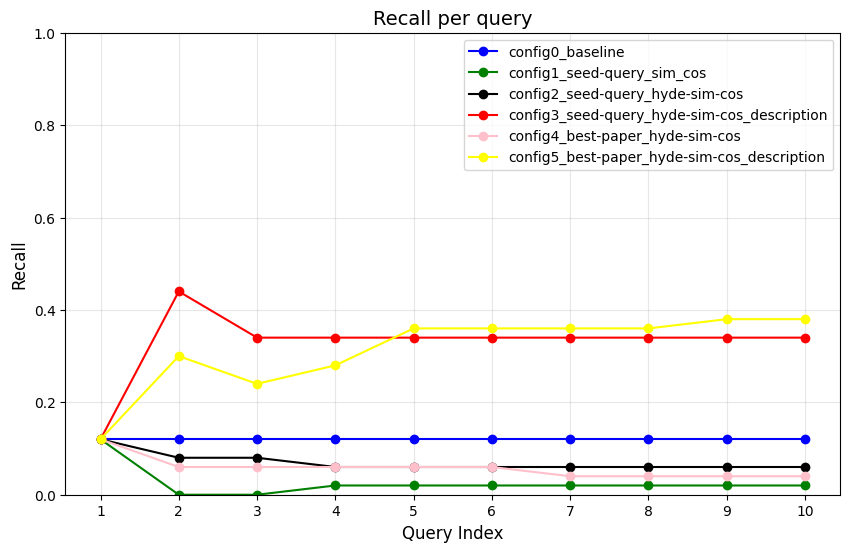

In [19]:
labelled_new_papers = pd.read_csv(labelled_new_papers_path)
labelled_dataset = pd.concat([labelled_new_papers,original_dataset], ignore_index=True)
labelled_dataset['relevance'] = labelled_dataset['relevance'].fillna(0)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'green', 'black', 'red', 'pink', 'yellow']

i=0
for crawler, path in crawlers.items(): 
    print(crawler)
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')
    color = colors[i]
    if crawler == 'config0_baseline':
        query = list(session_infos['all_queries'])[0]
        # kept_papers_by_query = {query:fetched_pages.iloc[:100]}
        kept_papers_by_query = {f"{query}_{i}": fetched_pages.iloc[:100] for i in range(10)}
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)
    fig, ax = plot_recall_precision(fig, ax,labelled_dataset, kept_papers_by_query, color, crawler, plot_recall=True)
    i+=1
    print('----------------------------------------------------')
plt.show()

nb pages total of original dataset:9
nb relevant pages of original dataset:6
nb pages total of labelled dataset:306
nb relevant pages of labelled dataset:50
---For 50 presented to the expert---
config0_baseline
nb pages found in total by crawler :9
nb relevant pages found in total by crawler :6
positions of relevant papers:[1, 2, 3, 4, 6, 7]
Position of last relevant pages : 7


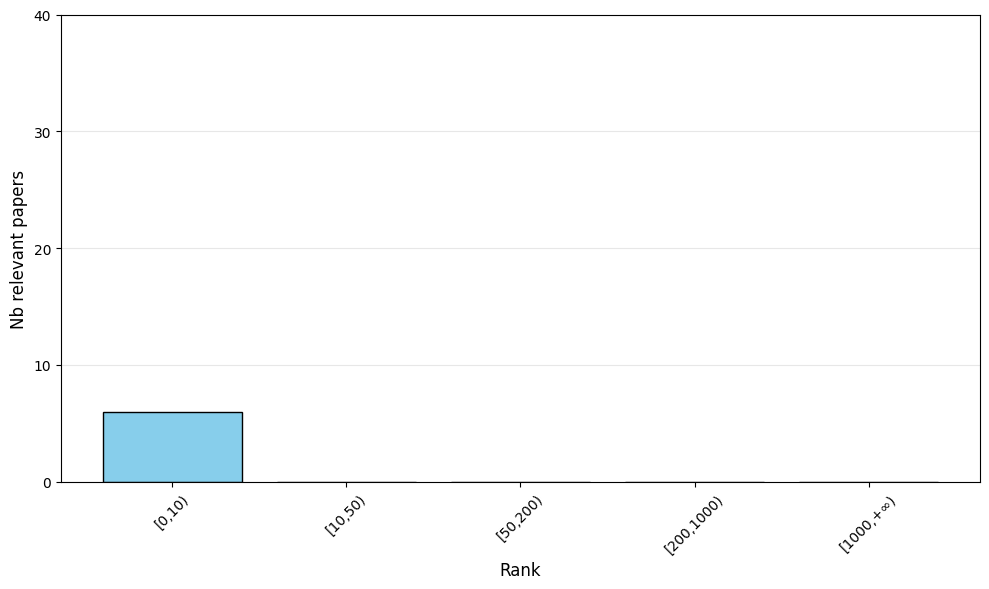

-----------------------------------------------
config1_seed-query_sim_cos
nb pages found in total by crawler :9789
nb relevant pages found in total by crawler :44
positions of relevant papers:[48, 51, 302, 409, 618, 935, 978, 1140, 1146, 1242, 1313, 1837, 1881, 1973, 2036, 2045, 2070, 2109, 2297, 2470, 2797, 2885, 3056, 3416, 3693, 3799, 3908, 4284, 4346, 4673, 5295, 5349, 5651, 5691, 5928, 6558, 6951, 7157, 7294, 7590, 7839, 8151, 8424, 9167]
Position of last relevant pages : 9167


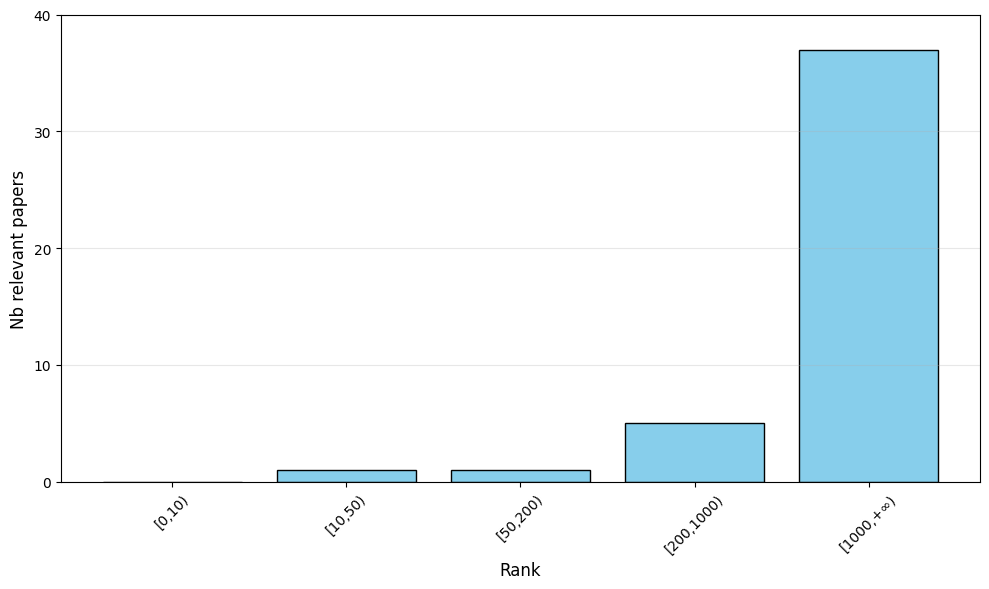

Number of relevant papers found when keeping 50 papers : 1
-----------------------------------------------
config2_seed-query_hyde-sim-cos
nb pages found in total by crawler :9789
nb relevant pages found in total by crawler :44
positions of relevant papers:[20, 21, 27, 79, 88, 105, 122, 125, 127, 157, 162, 179, 182, 206, 229, 251, 290, 334, 393, 394, 427, 523, 548, 601, 604, 768, 872, 1038, 1157, 1362, 1425, 1515, 1826, 2420, 2436, 2614, 2906, 3209, 4287, 4420, 4516, 5584, 6142, 8556]
Position of last relevant pages : 8556


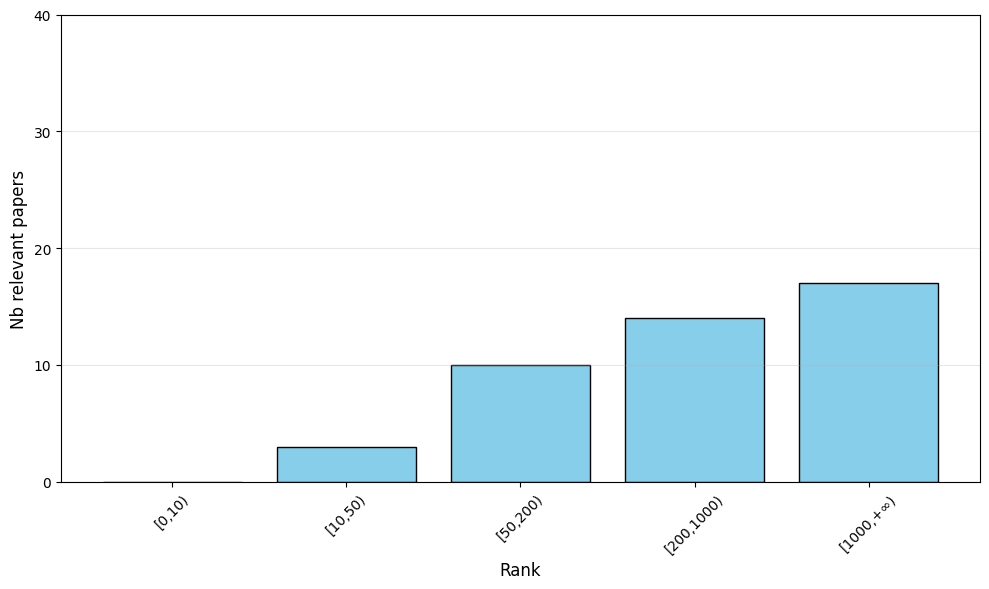

Number of relevant papers found when keeping 50 papers : 3
-----------------------------------------------
config3_seed-query_hyde-sim-cos_description
nb pages found in total by crawler :1913
nb relevant pages found in total by crawler :37
positions of relevant papers:[0, 2, 4, 8, 9, 11, 13, 14, 18, 23, 26, 27, 33, 39, 40, 41, 45, 52, 53, 64, 70, 79, 120, 125, 171, 195, 232, 239, 245, 290, 315, 353, 354, 422, 452, 585, 876]
Position of last relevant pages : 876


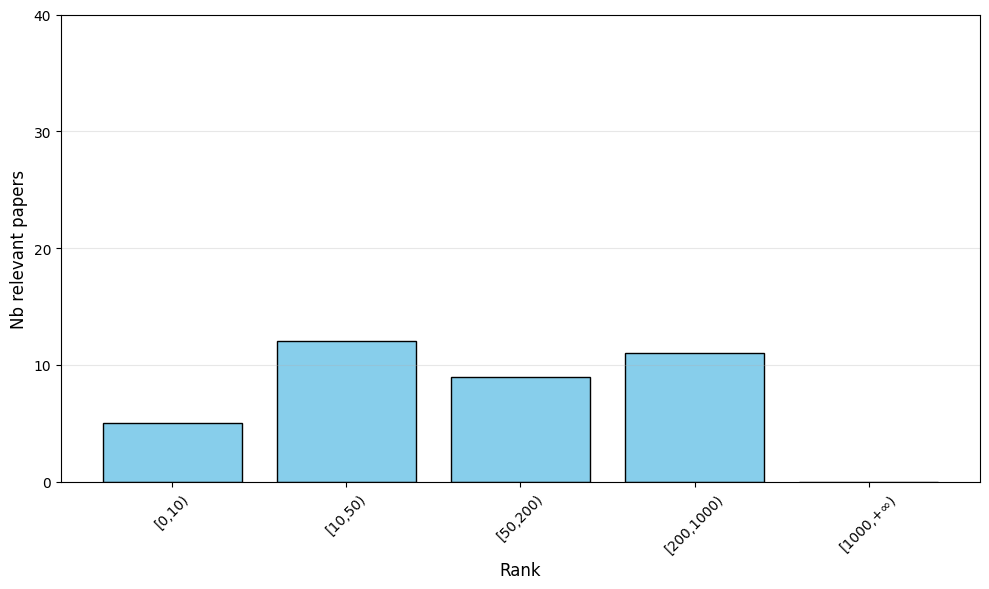

Number of relevant papers found when keeping 50 papers : 17
-----------------------------------------------
config4_best-paper_hyde-sim-cos
nb pages found in total by crawler :11201
nb relevant pages found in total by crawler :45
positions of relevant papers:[6, 19, 65, 80, 85, 89, 96, 98, 104, 125, 133, 145, 165, 169, 178, 210, 244, 248, 255, 284, 321, 331, 346, 406, 473, 586, 755, 855, 904, 961, 982, 984, 1408, 1430, 1869, 1915, 2156, 2177, 2262, 2983, 3450, 3595, 3814, 6035, 9794]
Position of last relevant pages : 9794


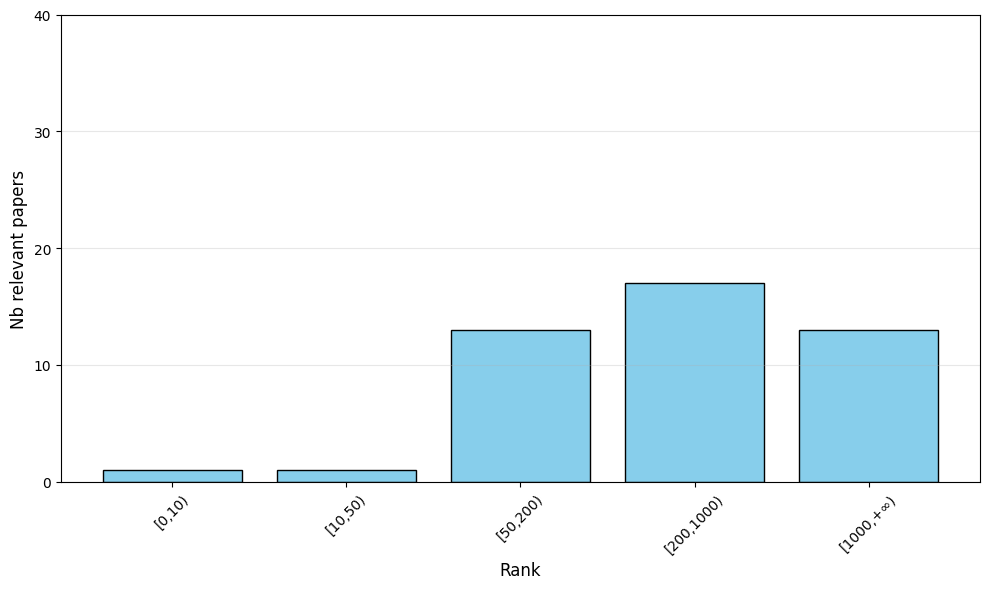

Number of relevant papers found when keeping 50 papers : 2
-----------------------------------------------
config5_best-paper_hyde-sim-cos_description
nb pages found in total by crawler :7788
nb relevant pages found in total by crawler :49
positions of relevant papers:[1, 2, 4, 6, 8, 9, 13, 14, 17, 25, 26, 31, 34, 39, 42, 43, 44, 48, 49, 52, 56, 62, 65, 66, 69, 71, 78, 80, 105, 115, 124, 139, 159, 188, 222, 223, 242, 273, 315, 316, 324, 330, 381, 404, 408, 506, 782, 1248, 1272]
Position of last relevant pages : 1272


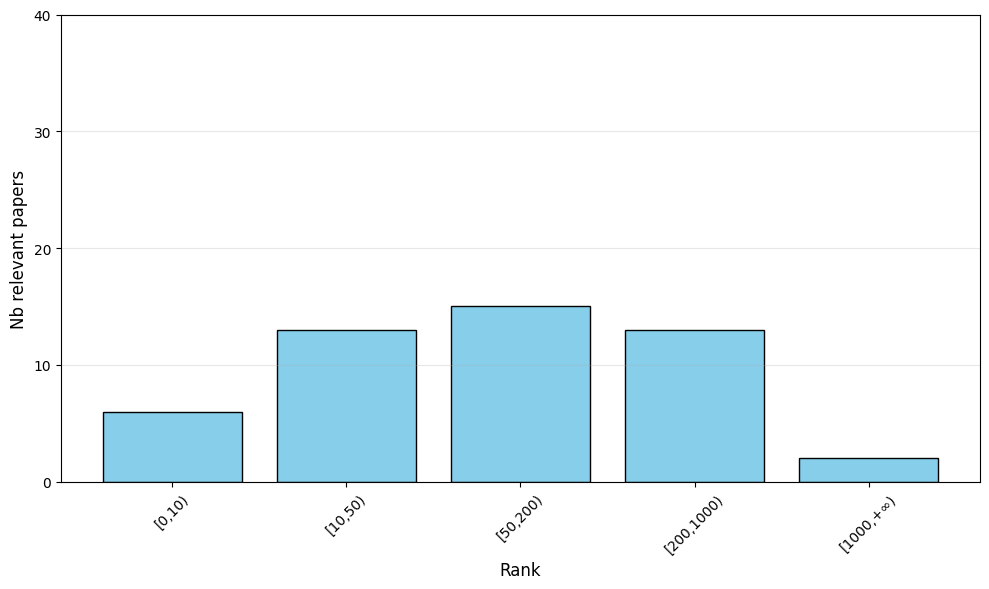

Number of relevant papers found when keeping 50 papers : 19
-----------------------------------------------


In [20]:
## recall and precision evolution by query

labelled_new_papers = pd.read_csv(labelled_new_papers_path)
labelled_dataset = pd.concat([labelled_new_papers,original_dataset], ignore_index=True)
print(f'nb pages total of original dataset:{len(original_dataset)}')
print(f'nb relevant pages of original dataset:{len(original_dataset[original_dataset["relevance"]==1])}')
print(f'nb pages total of labelled dataset:{len(labelled_dataset)}')
print(f'nb relevant pages of labelled dataset:{len(labelled_dataset[labelled_dataset["relevance"]==1])}')
print(f'---For {top_k} presented to the expert---')
for crawler, path in crawlers.items() : 
    print(crawler)
    fetched_pages = pd.read_csv(path + 'fetched_pages.csv')
    session_infos = pd.read_csv(path + 'session.csv')
    print(f'nb pages found in total by crawler :{len(fetched_pages)}')
    print(f'nb relevant pages found in total by crawler :{len(get_relevants(fetched_pages, labelled_dataset))}')
    
    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="right")
    merged_data_sorted = merged_data.sort_values(by="score", ascending=False)
    merged_data_sorted = merged_data_sorted.reset_index(drop=True)
    merged_data_sorted['relevance'] = merged_data_sorted['relevance'].fillna(0)
    relevants_sorted = merged_data_sorted[merged_data_sorted['relevance']==1]
    relevant_positions = relevants_sorted.index.tolist()
    print(f'positions of relevant papers:{relevant_positions}')
    max_position = relevant_positions[-1] if relevant_positions else 0
    print(f'Position of last relevant pages : {max_position}')
    b = [10, 50, 200, 1000]
    bins = [0] + b + [float('inf')]
    counts = [0] * (len(bins) - 1)
    for value in relevant_positions:
        for i in range(len(bins) - 1):
            if bins[i] <= value < bins[i + 1]:
                counts[i] += 1
                break
    intervals = [f"[{bins[i]},{bins[i+1]})" if bins[i+1] != float('inf') else f"[{bins[i]},+∞)" for i in range(len(bins) - 1)]
    result = {interval: count for interval, count in zip(intervals, counts)}
    # print("Résultats par intervalle :")
    # for interval, count in result.items():
    #     print(f"{interval} : {count}")
    categories = list(result.keys())
    values = list(result.values())

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(categories)), values, tick_label=categories, color='skyblue', edgecolor='black')
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Nb relevant papers', fontsize=12)
    # plt.yticks([0, 1, 2, 3, 4, 5])
    plt.yticks([0, 10, 20, 30, 40])
    # plt.suptitle('Ranking of relevant papers when sorting by score', fontsize=14)
    # plt.title('For configuration ' + crawler, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    if crawler == 'baseline':
        query = list(session_infos['all_queries'])[0]
        kept_papers_by_query = {query:fetched_pages.iloc[:100]}
    else : 
        kept_papers_by_query = keep_topk_by_query(session_infos, fetched_pages, top_k)

    i = 1
    for query, papers in kept_papers_by_query.items():
        recall, precision = recall_precision(papers, labelled_dataset)
        # print(f'Query {i}: {query}')
        # print(f'Recall: {recall}, Precision: {precision}')
        if i==10 : 
            print(f'Number of relevant papers found when keeping {top_k} papers : {len(get_relevants(papers, labelled_dataset))}')
        i += 1
    
    print('-----------------------------------------------')

        

50
Pages uniques trouvées 50 au total


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

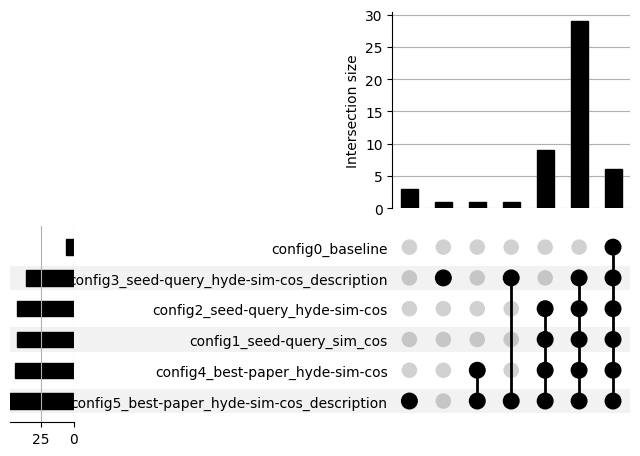

In [106]:
labelled_new_papers = pd.read_csv(labelled_new_papers_path)
labelled_dataset = pd.concat([labelled_new_papers,original_dataset], ignore_index=True)
relevance_threshold = 1
df_relevants = labelled_dataset[labelled_dataset['relevance']==1]

def get_fetched_df(path) :
    return(pd.read_csv(path + 'fetched_pages.csv'))

combined_df = pd.concat([get_fetched_df(path)['url'] for path in list(crawlers.values())]).drop_duplicates().reset_index(drop=True)
combined_df = pd.DataFrame(combined_df, columns=['url'])  # Convertir en DataFrame
combined_df = pd.merge(combined_df, df_relevants, on='url', how='right').fillna(0)
print(len(combined_df))

print(f'Pages uniques trouvées {len(combined_df)} au total')

# Initialiser les colonnes pour chaque crawler avec des 0
for crawler_name in crawlers.keys():
    combined_df[crawler_name] = 0  # Initialise with 0

# Marquer les URLs trouvées par chaque crawler avec 1
for crawler_name, path in crawlers.items():
    combined_df[crawler_name] = combined_df['url'].isin(get_fetched_df(path)['url']).astype(int)

# Supprimer la colonne 'url' et définir les colonnes des crawlers comme index
combined_df = combined_df.set_index(list(crawlers.keys()))

# Utiliser UpSet pour générer le diagramme
upset = UpSet(combined_df, subset_size='count', sort_by='degree')
upset.plot()

# Afficher le graphique
plt.show()